In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from nice.algorithms.connectivity import epochs_compute_wsmi
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


from scipy.ndimage import gaussian_filter1d

def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

sigma = 2

#have been preprocessing once i have picked out the trials. i should really just do this across all of the data, and then pick out the trials to use. 
#might only be able to do this within each dataset

# def preprocess(data):
#     data = detrend(data, axis=0)
#     epsilon = 1e-9
#     data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
#     return data

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds > 1e-6
    if len(non_constant_cols) != 0:
        print('non constant column at ', np.where(non_constant_cols == False))
                

    constant_cols = stds < 1e-6

    z = np.zeros_like(data[:, :])
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)
    z[:, constant_cols] = np.mean(data[:, constant_cols], axis = 0)

    #unsure what to replace lost values with, for now replacing with 0

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


#this can run all of the pairs in ~ 
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)


agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_SP_attleft_agg = copy.deepcopy(agg_structure)
right_input_SP_attleft_agg = copy.deepcopy(agg_structure)
attention_SP_attleft_agg = copy.deepcopy(agg_structure)

left_input_SP_attright_agg = copy.deepcopy(agg_structure)
right_input_SP_attright_agg = copy.deepcopy(agg_structure)
attention_SP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file & extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
    # left_input_SP (2032, 500, 160)
    # right_input_SP (2032, 500, 160)
    # attention_SP (2032, 500, 80)
    
    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    sigma = 2

    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80
                
    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention


    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)

    #preprocess here now that we have traces of all of the relavant trials
    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)

    #so now for each dataset we have a preprocessed set of LFP like signals

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices=True)
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]
            _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices=True)

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty
          
            if len(left_indices) >= 1: 
                left_in_SP_attleft = left_input_SP[left_indices, 100:350]
                right_in_SP_attleft = right_input_SP[left_indices, 100:350]
                attention_layer_SP_attleft = attention_SP[left_indices, 100:350] 


                left_input_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_SP_attleft)
                right_input_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_SP_attleft)
                attention_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_layer_SP_attleft)


            if len(right_indices) >= 1:
                left_in_SP_attright = left_input_SP[right_indices, 100:350]
                right_in_SP_attright = right_input_SP[right_indices, 100:350]
                attention_layer_SP_attright = attention_SP[right_indices, 100:350]

            
                left_input_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_SP_attright)   
                right_input_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_SP_attright)
                attention_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_layer_SP_attright)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}

for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


Dataset 1 loaded in 8.44 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
Dataset 1 processed in 18.37 seconds
Dataset 2 loaded in 21.18 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0, 1, 2]),)
Dataset 2 processed in 32.43 seconds
Dataset 4 loaded in 16.92 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0]),)
Dataset 4 processed in 12.86 seconds
Dataset 8 loaded in 12.97 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0, 1]),)
Dataset 8 processed in 18.55 seconds
Dataset 14 loaded in 17.67 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non const

Total load time = 344.15 seconds
attention_input_SP_attleft_all 01 raw = [[-0.05313081  0.46672982  0.98224442 ...  0.53746211  0.66757059
   1.00422897]
 [ 0.1952168   0.20401297  0.22190563 ... -0.2315566  -0.25306991
  -0.24057085]
 [-1.03755184 -1.0055813  -0.99868075 ...  0.64541848  0.64122265
   0.55909894]
 ...
 [-0.85946349 -0.77374831 -0.62922139 ...  1.47944541  1.48853797
   1.29710524]
 [-0.54868391 -0.60444588 -0.7242827  ...  0.59188733  0.64527447
   0.63129132]
 [-0.28813319 -0.48093468 -0.63039493 ... -0.08437588 -0.00867675
   0.04275378]]
checking 01:---------------------- [[-0.05313081  0.46672982  0.98224442 ...  0.53746211  0.66757059
   1.00422897]
 [ 0.1952168   0.20401297  0.22190563 ... -0.2315566  -0.25306991
  -0.24057085]
 [-1.03755184 -1.0055813  -0.99868075 ...  0.64541848  0.64122265
   0.55909894]
 ...
 [-0.85946349 -0.77374831 -0.62922139 ...  1.47944541  1.48853797
   1.29710524]
 [-0.54868391 -0.60444588 -0.7242827  ...  0.59188733  0.64527447
   0.

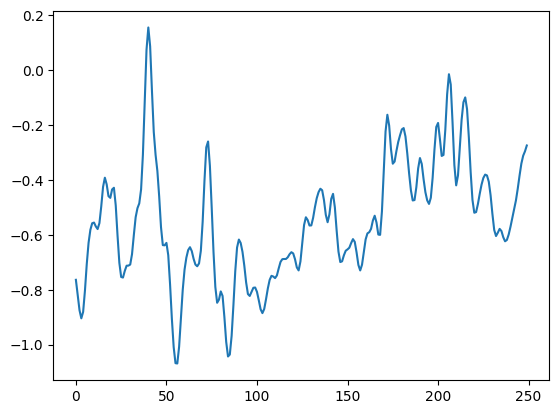

In [4]:
#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_input_SP_attleft_all = copy.deepcopy(all_structure)
right_input_SP_attleft_all = copy.deepcopy(all_structure)
attention_SP_attleft_all = copy.deepcopy(all_structure)

left_input_SP_attright_all = copy.deepcopy(all_structure)
right_input_SP_attright_all = copy.deepcopy(all_structure)
attention_SP_attright_all = copy.deepcopy(all_structure)

for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

#------ want to preprocess each array here now that they are properly compiled ----------------
#looking first at the shape / structure of left_input_SP_attleft_all:

for class_left in classes_left:
        for class_right in classes_right:
            left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

print('attention_input_SP_attleft_all 01 raw =', attention_SP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])

print('checking 01:----------------------', attention_SP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])
plt.plot(attention_SP_attleft_all[f'left_class_{1}'][f'right_class_{1}'][0])
plt.show()

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)

for class_left in classes_left:
    for class_right in classes_right:
        left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_SP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

        left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_SP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])


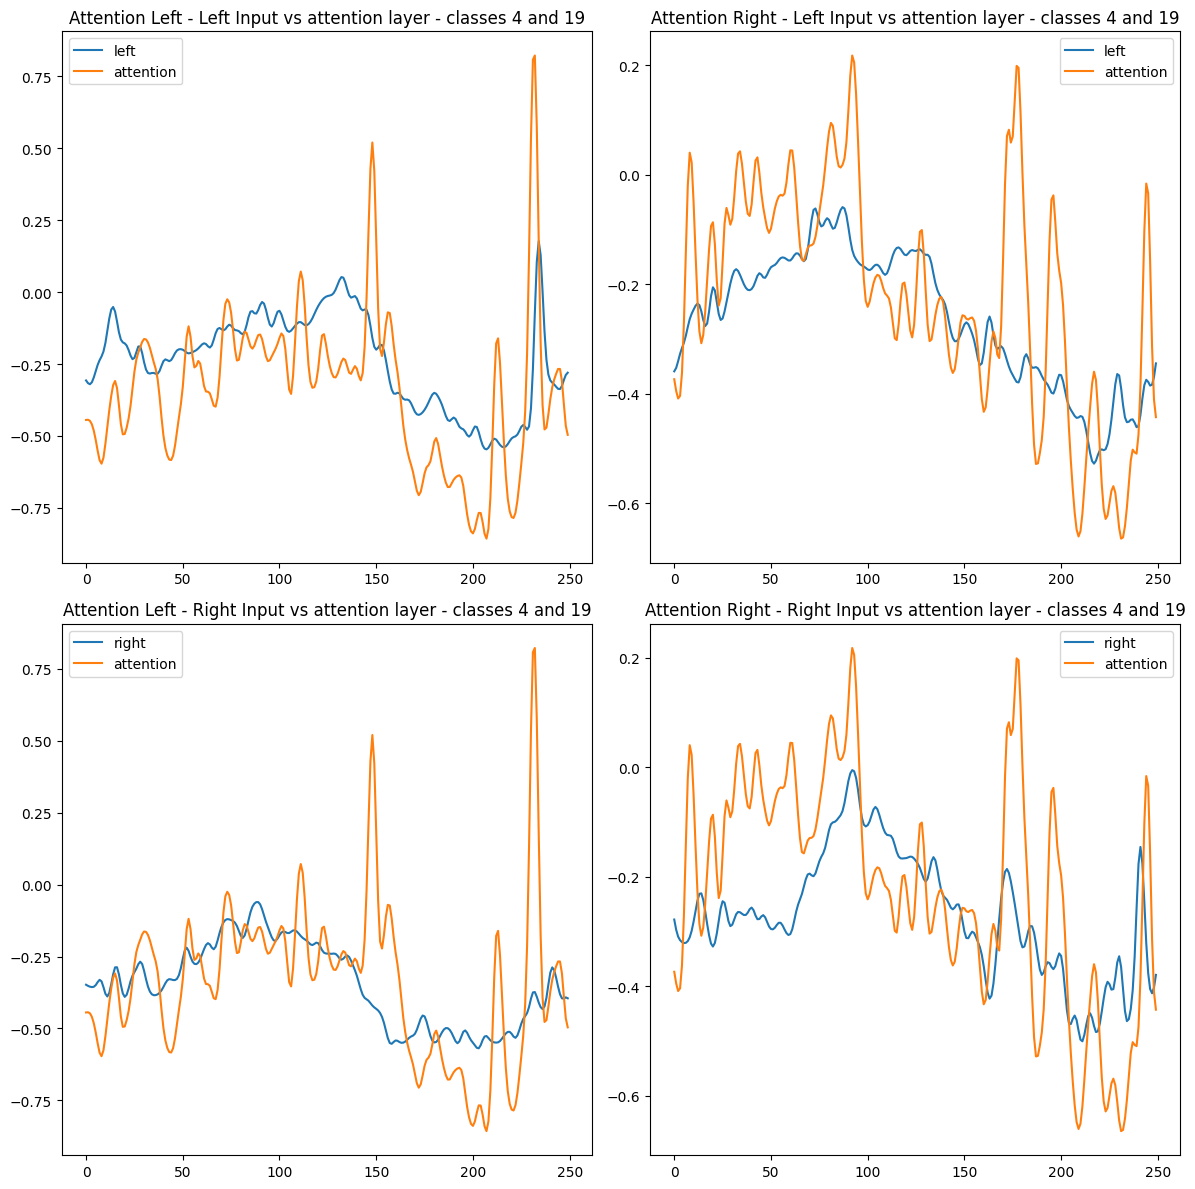

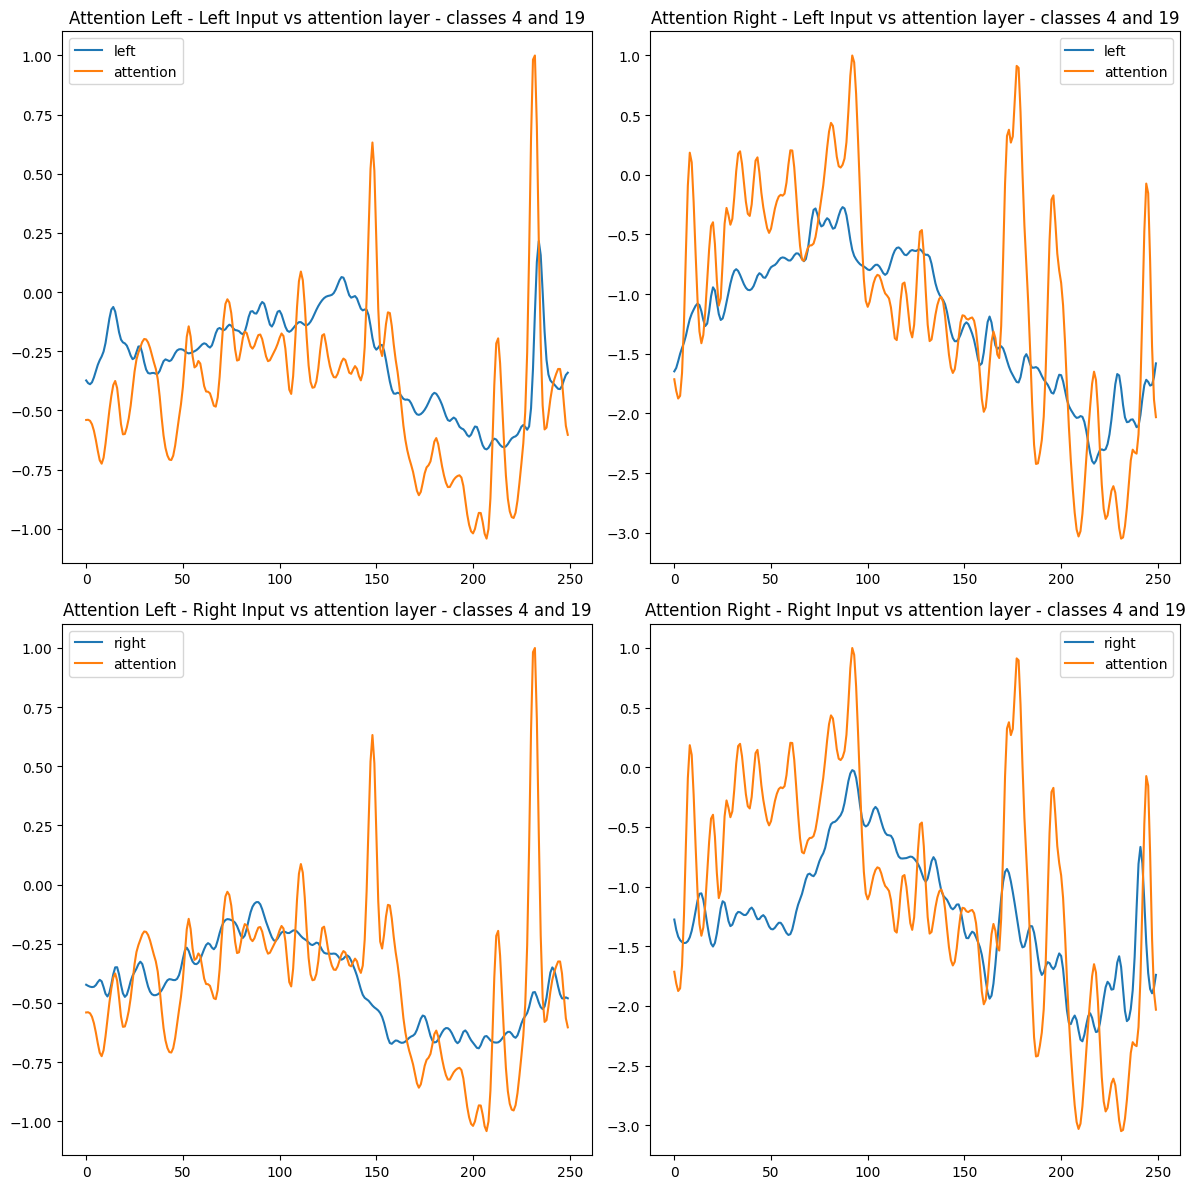

In [5]:
mean_left_attleft = copy.deepcopy(all_structure)
mean_right_attleft = copy.deepcopy(all_structure)
mean_attention_attleft = copy.deepcopy(all_structure)

mean_left_attright = copy.deepcopy(all_structure)
mean_right_attright = copy.deepcopy(all_structure)
mean_attention_attright = copy.deepcopy(all_structure)


#here take mean across all trials for each class pair
for class_left in classes_left:
    for class_righti in classes_right:
        mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = np.mean(left_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)
        mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attleft[f'left_class_{class_left}'][f'right_class_{class_left}'], axis = 0)

        mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)


##will select a class pair and plot the traces 
left, right = 4, 19
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
ax[0, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right')
ax[1, 1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()


#---------- plotting normalised data ----------------
def norm_left(data):
    return data / max(np.max(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']), np.max(data))
                      
def norm_right(data):
    return data / max(np.max(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}']), np.max(data))


fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(norm_left(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='left')
ax[0, 0].plot(norm_left(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='attention')
ax[0, 0].set_title(f'Attention Left - Left Input vs attention layer - classes {left} and {right}')
ax[0, 0].legend()

ax[1, 0].plot(norm_left(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='right')
ax[1, 0].plot(norm_left(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='attention')
ax[1, 0].set_title(f'Attention Left - Right Input vs attention layer - classes {left} and {right}')
ax[1, 0].legend()

ax[0, 1].plot(norm_right(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='left')
ax[0, 1].plot(norm_right(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='attention')
ax[0, 1].set_title(f'Attention Right - Left Input vs attention layer - classes {left} and {right}')
ax[0, 1].legend()

ax[1, 1].plot(norm_right(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='right')
ax[1, 1].plot(norm_right(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}']) , label='attention')
ax[1, 1].set_title(f'Attention Right - Right Input vs attention layer - classes {left} and {right}')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

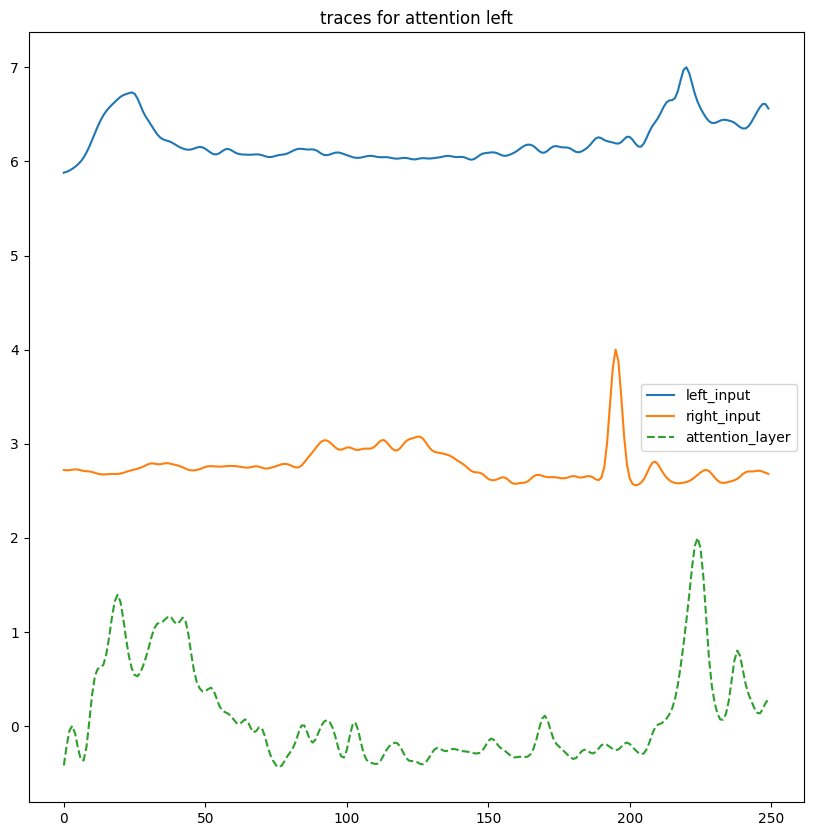

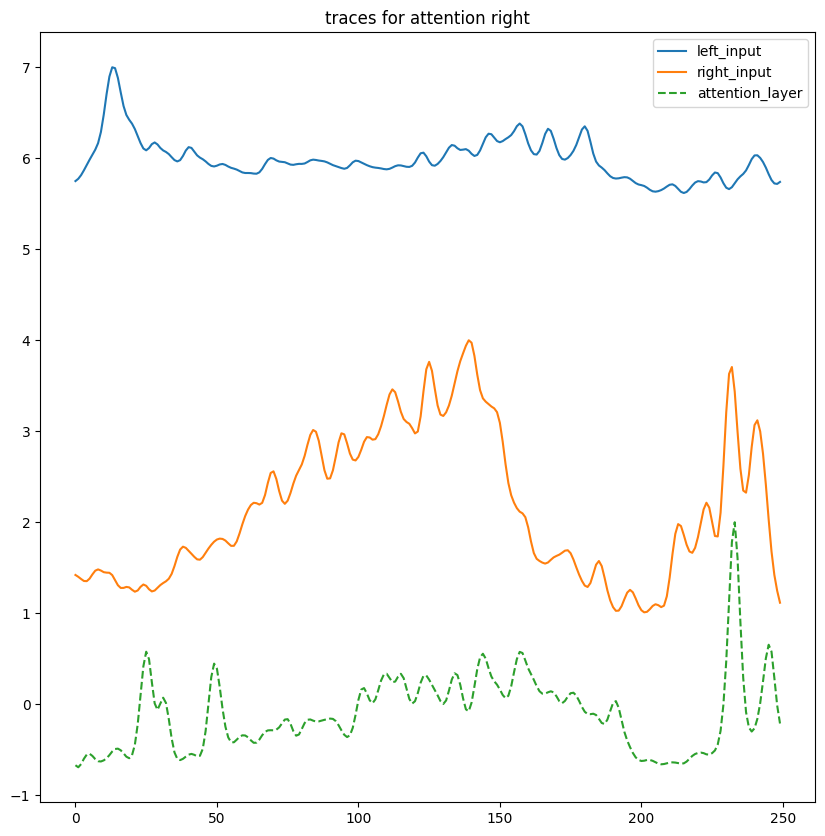

In [6]:
#-------------wsmi calculation----------------
n_times = 250
dt = 0.002
sfreq = 1 / dt

ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right: 
     
        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] ,
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        #print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        #print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        #print("raw_data_left =", raw_left)


        events_left = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498, baseline=None, preload=True)

        # if class_left == 0 and class_right == 1:
        #     print('raw_data_left =', raw_data_left)
        #     print('raw_data_left reshaped =', raw_data_left.shape)
        #     print('raw_left =', raw_left)
        #     #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        #     epochs_left.plot(n_epochs = 2, n_channels=3, scalings = 'auto', title="Attention Left")
        #     plt.show()

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(raw_data_left[0][0:250])
            NR = np.max(raw_data_left[1][0:250])
            NA = np.max(raw_data_left[2][0:250])
            plt.plot((raw_data_left[0][0:250] / NL)+6, label='left_input')
            plt.plot((raw_data_left[1][0:250] / NR)+3, label='right_input')
            plt.plot(2 *raw_data_left[2][0:250] / NA, label='attention_layer', linestyle='--')
            plt.title('traces for attention left')
            plt.legend()
            plt.show()


for class_left in classes_left:
    wsmi_start = time.time()
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            print('no trials for this class pair')
            continue        

        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] 
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        events_right = np.array([[i * n_times, 0, 1] for i in range(n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 
        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)

        if class_left == left and class_right == right:
            plt.figure(figsize=(10, 10))
            NL = np.max(raw_data_left[0][0:250])
            NR = np.max(raw_data_left[1][0:250])
            NA = np.max(raw_data_left[2][0:250])
            plt.plot((raw_data_left[0][0:250] / NL)+6, label='left_input')
            plt.plot((raw_data_left[1][0:250] / NR)+3, label='right_input')
            plt.plot(2 * raw_data_left[2][0:250] / NA, label='attention_layer', linestyle='--')
            plt.title('traces for attention right')
            plt.legend()
            plt.show()